<a href="https://colab.research.google.com/github/anaguilarar/Crop_DL/blob/main/Rice_seeds_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To boost the process, please use gpu, habilitate the option in:
 runtime -> change runtime type -> hardware accelerator -> gpu . 

In [13]:
import os
if not os.path.exists("Crop_DL") and not os.getcwd().endswith("Crop_DL"):
    !git clone https://github.com/anaguilarar/Crop_DL.git
    print("Cloned")
    
else:
    print("crop_dl directory already exists")
if not os.getcwd().endswith("Crop_DL"):
  os.chdir("Crop_DL")

from crop_dl.seeds.rice_counting import RiceSeedsCounting
from crop_dl.models.dl_initilizer import DLInstanceModel
from crop_dl.models.utils import check_weigth_path, downloadzip

import matplotlib.pyplot as plt
import torch
import os

crop_dl directory already exists


### Configuration

Here the user defines the folder's name that contains the images that will be analyzed.
Likewise, the model will be updated with a pre-trained version. this version is stored in an amazon bucket


In [14]:
IMAGESPATH = "example_imagery/seeds"
WEIGHTSURL= "https://dlmodels-bucket.s3.ap-northeast-1.amazonaws.com/maskrcnn_rice_seeds_2.zip"

WEIGHTSPATH = check_weigth_path(WEIGHTSURL, suffix="checkpoint", weights_path="model_weights")


['maskrcnn_rice_seeds_20230313-215924/checkpoint']


### Setting the model and datasets

Crurrently the model anlise either images saved as ".jpg" or ".png", i f both files are in a same folder it eill only process the ones that were set in imagessuffix. 



In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
PREDICTION_CONFIDENCE = 0.75
seed_model = DLInstanceModel(WEIGHTSPATH,
                 device = device)

ricecounts = RiceSeedsCounting(
                 IMAGESPATH,
                 seed_model.model, 
                 imagessuffix = ".jpg",
                 device = device)

print("files available in folder: ",ricecounts.listfiles)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


weights loaded
files available in folder:  ['test9.jpg', 'test3.jpg', 'test10.jpg', 'test8.jpg', 'test2.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test4.jpg', 'test.jpg', 'test11.jpg']


### Detecting the rice seeds in an image

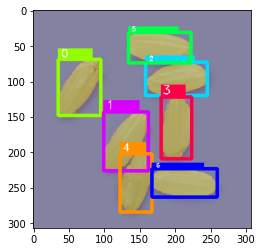

In [16]:
import cv2

img_number = 1
ricecounts.detect_rice(img_number, keepsize=True, segment_threshold = 170, threshold = PREDICTION_CONFIDENCE)
m = ricecounts.plot_prediction(only_image=True)
plt.imshow(m[:,:,[2,1,0]])


In [17]:
## Run this cell if you want to export the above image
cv2.imwrite("pred_{}".format(ricecounts.listfiles[ricecounts.idimg]), m)

True

#### Extracting information for a single seed

{'fn': ['test3.jpg'], 'seed_id': [2], 'height': [86.97700845625813], 'width': [43.68065933568311], 'area': [3127.0]}


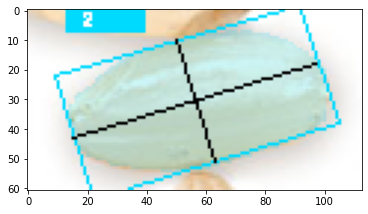

In [18]:
seed_number = 2
m = ricecounts.plot_individual_seed(seed_number)
print(ricecounts.calculate_oneseed_metrics(seed_number))
plt.imshow(m[:,:,[2,1,0]])

#### Extracting information for all seeds

In [19]:
filename = "{}_data.csv".format(
    ricecounts.listfiles[ricecounts.idimg][:ricecounts.listfiles[ricecounts.idimg].index(".jpg")])

df = ricecounts.one_image_seeds_summary()
df.to_csv(filename)
print(f"the data was saved in {filename}")
df


the data was saved in test3_data.csv


,fn,seed_id,height,width,area
0,test3.jpg,0,89.587946,39.661064,3003.0
0,test3.jpg,1,94.302704,40.496913,3254.0
0,test3.jpg,2,86.977008,43.680659,3127.0
0,test3.jpg,3,86.000000,42.000000,3099.0
0,test3.jpg,4,85.702975,40.162171,2811.0
0,test3.jpg,5,87.000000,41.000000,3235.0
0,test3.jpg,6,90.000000,39.000000,3116.0


#### Extracting the data for all the files that are inside the folder

In [20]:
filename = "all_data.csv"
df = ricecounts.all_image_seeds_summary(threshold = PREDICTION_CONFIDENCE)
df.to_csv(filename)
df

100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


,fn,seed_id,height,width,area
0,test9.jpg,0,32.649655,16.552945,476.0
0,test3.jpg,0,89.587946,39.661064,3003.0
0,test3.jpg,1,94.302704,40.496913,3254.0
0,test3.jpg,2,86.977008,43.680659,3127.0
0,test3.jpg,3,86.000000,42.000000,3099.0
...,...,...,...,...,...
0,test11.jpg,10,387.138218,213.775583,65002.0
0,test11.jpg,11,377.000000,228.000000,67051.0
0,test11.jpg,12,377.000000,239.000000,69646.0
0,test11.jpg,13,322.000000,230.000000,58213.0


100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


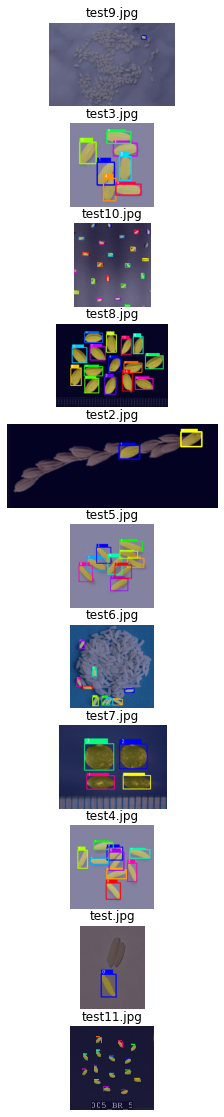

In [ ]:
images = ricecounts.all_image_predictions(threshold = PREDICTION_CONFIDENCE)

f, ax = plt.subplots(nrows=len(images), ncols=1, figsize = (10,20))

for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_axis_off()
    ax[i].set_title(ricecounts.listfiles[i])

##### Exporting all images predictions

In [21]:
outputpath = "predictions"
compress_folder = True

ricecounts.export_all_imagery_predictions(outputpath=outputpath,
                                          saveaszip= compress_folder)


100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Saving in: predictions


### Uaing Images located in google drive

to use this function first, we need to  mount our google drive folder on this colab. For that you will need to facilitate the access through the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### setting google drive folder 
If the previous step was correctly done, in the left panel you will see a new folder called drive. 
Using this panel you can find the folder that contains the images. Once that you found it, you can right click and then click in copy the path and paste it in next cell.
Or if you know the path just paste it after "MyDrive/"

In [ ]:

IMAGESPATH = "/content/drive/MyDrive/rice_images"

ricecounts = RiceSeedsCounting(
                 IMAGESPATH,
                 seed_model.model, 
                 imagessuffix = ".jpg",
                 device = device)

print("files available in folder: ",ricecounts.listfiles)



files available in folder:  ['126_Deshi Boro.jpg', '124_Jaishto Boro.jpg', '122_Guchi Boro.jpg', '123_Ishamoti.jpg', '125_Kalizira.jpg', '120_Begun Bichi.jpg', '121_Bogra Deshi.jpg']


#### export predictions to My drive

In [ ]:
filename = "/content/drive/MyDrive/all_data.csv"
df = ricecounts.all_image_seeds_summary(threshold = PREDICTION_CONFIDENCE)
df.to_csv(filename)

100%|██████████| 7/7 [00:26<00:00,  3.81s/it]


In [ ]:
outputpath = "/content/drive/MyDrive/predictions"
compress_folder = True

ricecounts.export_all_imagery_predictions(outputpath=outputpath,
                                          saveaszip= compress_folder)


100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


Saving in: /content/drive/MyDrive/predictions
